In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi #https://github.com/Kaggle/kaggle-api
import os
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
from spacy.util import minibatch
import random

In [2]:
# Use Kaggle API to download train.csv, test.csv
api = KaggleApi()
api.authenticate()
api.competition_download_files('nlp-getting-started')

# Unzip files
os.system('unzip *.zip');

In [3]:
# Define utility functions

def load_data(csv_file):
    """Returns texts and labels in format {"real": bool(target), "not": not bool(target)} 
       for each (text,target) example from csv_file in shuffled order
    
        Arguments
        ---------
        csv_file: string of csv file name with columns 'id', 'keyword', 'location', text', 'target'
    """
    data = pd.read_csv(csv_file)

    # Shuffle data
    shuffled_data = data.sample(frac=1, random_state=1)

    # Define texts from 'text' column and labels from 'target' column (HB: remember to use 'keyword','location' columns too)
    texts = shuffled_data['text'].values
    labels = [{"real": bool(target), "not": not bool(target)}
              for target in shuffled_data['target'].values] 
    
    return texts, labels

def split_data(texts, labels, split_ratio=0.9):
    """Returns set1 texts, set1 labels, set2 texts, set2 labels for each (texts,label) example
    
        Arguments
        ---------
        texts: list of texts
        labels: list of labels
        split_ratio: float {# of set1 examples} / {# of set2 examples} 
    """
    # Convert split ratio to a split index
    split_idx = int(len(texts) * split_ratio)
    
    # Split set1 and set2 texts
    set1_texts = texts[:split_idx]
    set2_texts = texts[split_idx:]

    # Split set1 and set2 labels
    set1_labels = labels[:split_idx]
    set2_labels = labels[split_idx:]
    
    return set1_texts, set1_labels, set2_texts, set2_labels

def convert_to_cats(original_labels):
    """Returns labels as a dictionary keyed by 'cats' required by a spaCy TextCategorizer
    
        Arguments
        ---------
        original_labels: list of labels
    """
    converted_labels = [{'cats': labels} for labels in original_labels]
    
    return converted_labels

def train(model, train_data, optimizer, minibatch_size=8):
    losses = {}
    random.seed(1)
    random.shuffle(train_data) # re-shuffle the training data each time train() is called

    # Create the batch generator of minibatches with minibatch_size
    batches = minibatch(train_data, size=minibatch_size)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        model.update(texts, labels, sgd=optimizer, losses=losses)

    return losses # return loss as a dictionary {model’s name : accumulated loss}

def predict(model, texts): 
    # Use the model's tokenizer to tokenize each input text
    docs = [model.tokenizer(text) for text in texts]

    # Use textcat to get the scores for each doc
    textcat = model.get_pipe('textcat')
    scores, _ = textcat.predict(docs)

    # From the scores, find the class with the highest score/probability
    predicted_class = scores.argmax(axis=1)

    return predicted_class

def evaluate(model, texts, labels):
    """ Returns the accuracy of a TextCategorizer model.

        Arguments
        ---------
        model: spaCy model with a TextCategorizer
        texts: Text samples, from load_data function
        labels: True labels, from load_data function

    """
    # Extract TextCategorizer from the nlp pipeline
    textcat = model.get_pipe('textcat')
    
    # Get predictions from textcat model 
    predicted_class = predict(model, texts)

    # Create a boolean list indicating correct predictions
    correct_predictions = [label['cats'][textcat.labels[pred]] for pred, label in zip(predicted_class, labels)]

    # Calculate the accuracy i.e. the number of correct predictions divided by all predictions
    accuracy = sum(correct_predictions)/len(predicted_class)

    return accuracy

def spacy_model(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, fraction=1.0, num_epochs = 10, minibatch_size = 8, architecture='simple cnn'):
    """Returns spaCy model, 
       and a list of (train_texts, train_labels) from the fraction of training data used in training
    
        Arguments
        ---------
        train_texts: list of texts from training set
        train_labels: list of labels from training set
        val_texts: list of texts from validation set
        val_labels: list of labels from validation set
        test_texts: list of texts from test set
        test_labels: list of labels from test set
        fraction: float fraction of training set to be used to train model
        num_epochs: integer number of epochs of the optimization loop
        minibatch_size: integer size of a minibatch
        architecture: string architecture choice
                      'ensemble' i.e. ensembled bag-of-words + CNN with mean pooling & attention
                      'simple cnn' i.e. vectors are mean pooled and used as features in a CNN
                      'bow' i.e. bag-of-words
    """
    # Create blank Language class
    nlp = spacy.blank("en")

    # Create a TextCategorizer with exclusive classes
    textcat = nlp.create_pipe(
                  "textcat",
                  config={
                    "exclusive_classes": True,
                    "architecture": architecture})

    # Add the TextCategorizer to the nlp pipeline
    nlp.add_pipe(textcat)

    # Add labels to text classifier
    textcat.add_label("real")
    textcat.add_label("not")

    # Fix seed for reproducibility
    spacy.util.fix_random_seed(1)
    random.seed(1)

    # Create training data
    train_data = list(zip(train_texts, train_labels))
    
    # Convert fraction to a fraction index
    fraction_idx = int(len(train_data) * fraction)
    
    # Keep only a fraction of training data
    fraction_data = train_data[:fraction_idx]
    
    # Train and on-the-fly evaluate on the training set in a loop, num_epochs times
    optimizer = nlp.begin_training()
    for i in range(num_epochs):
        losses = train(nlp, fraction_data, optimizer, minibatch_size=minibatch_size)
        fraction_accuracy = evaluate(nlp, *zip(*fraction_data))
        print(f"Loss after epoch {i}: {losses['textcat']:.3f} \t Accuracy ({fraction} of training set): {fraction_accuracy:.3f}")
    
    # Print success
    print(f"---------------------------------------------")
    print(f"spaCy model trained... saving")
    print(f"---------------------------------------------")
        
    return nlp, fraction_data

In [8]:
##########################################################################################################
# Predictions
##########################################################################################################

# Load data into texts list and labels list
texts, labels = load_data('train.csv')

# Make train/val/test split
train_texts, train_labels, remnant_texts, remnant_labels = split_data(texts, labels, split_ratio=0.9)
val_texts, val_labels, test_texts, test_labels = split_data(remnant_texts, remnant_labels, split_ratio=0.5)

# Convert labels into a dictionary keyed by 'cats' required by a spaCy TextCategorizer
train_labels = convert_to_cats(train_labels)
val_labels   = convert_to_cats(val_labels)
test_labels  = convert_to_cats(test_labels)

# Create spaCy model
nlp, _ = spacy_model(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels)

# Evaluate model on the training set and on the validation set
train_accuracy = evaluate(nlp, train_texts, train_labels)
val_accuracy = evaluate(nlp, val_texts, val_labels)
print(f"Training set accuracy: {train_accuracy:.3f}")
print(f"Validation set accuracy: {val_accuracy:.3f}")

# Extract TextCategorizer from the nlp pipeline
textcat = nlp.get_pipe('textcat')

# Make predictions with model on test set and convert predicted_clas to 'real' or 'not'
predicted_class = predict(nlp, test_texts)
f = open('predictions_on_test_set.txt', 'a')
for pred, text, label in zip(predicted_class, test_texts, test_labels):
    if label['cats'][textcat.labels[pred]]:
        f.write(f"{textcat.labels[pred]} (correct): {text} \n") 
    else:
        f.write(f"{textcat.labels[pred]} (incorrect): {text} \n")
print(f"\n---Example-by-example predictions ... saved in predictions_on_test_set.txt--- \n\n")


---Example-by-example predictions ... saved in predictions_on_test_set.txt--- 




Training model with 0.1 of the training set
Loss after epoch 0: 0.635 	 Accuracy (0.1 of training set): 0.832
---------------------------------------------
spaCy model trained... saving
---------------------------------------------
Training model with 0.2 of the training set
Loss after epoch 0: 1.207 	 Accuracy (0.2 of training set): 0.805
---------------------------------------------
spaCy model trained... saving
---------------------------------------------
Training model with 0.3 of the training set
Loss after epoch 0: 1.788 	 Accuracy (0.3 of training set): 0.819
---------------------------------------------
spaCy model trained... saving
---------------------------------------------
Training model with 0.4 of the training set
Loss after epoch 0: 2.304 	 Accuracy (0.4 of training set): 0.813
---------------------------------------------
spaCy model trained... saving
---------------------------------------------
Training model with 0.5 of the training set
Loss after epoch 0: 4.065 	 

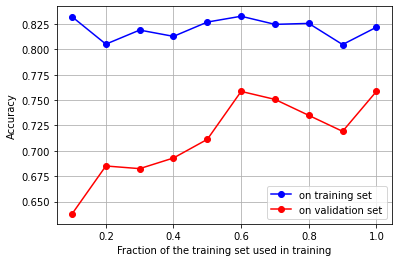

In [9]:
##########################################################################################################
# Learning curves
##########################################################################################################
import matplotlib.pyplot as plt

# Load data into texts list and labels list
texts, labels = load_data('train.csv')

# Make train/val/test split
train_texts, train_labels, remnant_texts, remnant_labels = split_data(texts, labels, split_ratio=0.9)
val_texts, val_labels, test_texts, test_labels = split_data(remnant_texts, remnant_labels, split_ratio=0.5)

# Convert labels into the dictionary format with the key 'cats' that a spaCy TextCategorizer requires
train_labels = convert_to_cats(train_labels)
val_labels   = convert_to_cats(val_labels)
test_labels  = convert_to_cats(test_labels)

# Define fractions of the training set to train on
fraction_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fraction_accuracy_list = []
val_accuracy_list = []

for fraction in fraction_list:
    print(f"Training model with {fraction} of the training set")
    
    # Create spaCy models using varying fractions of the training set, and train for only one epoch each
    nlp, fraction_data = spacy_model(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, fraction=fraction, num_epochs = 1)
    
    # Evaluate model on a fraction of the training set and on the validation set
    fraction_accuracy = evaluate(nlp, *zip(*fraction_data))
    val_accuracy = evaluate(nlp, val_texts, val_labels)
    
    # Append to accuracy lists
    fraction_accuracy_list.append(fraction_accuracy)
    val_accuracy_list.append(val_accuracy)

# Plot (fraction_list, fraction_accuracy_list) and (fraction_list, val_accuracy_list)
plt.clf()
plt.plot(fraction_list,fraction_accuracy_list, color=(0,0,1,1), marker='o', label='on training set')
plt.plot(fraction_list,val_accuracy_list, color=(1,0,0,1), marker='o', label='on validation set')
plt.xlabel('Fraction of the training set used in training')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.savefig("learning_curves_" + str(fraction_list[0]) + "-" + str(fraction_list[-1]) + ".png")